# Basic regression with ARIMA errors.

This notebook contains an implemenation of regression with ARIMA errors.

In this implementation months of the year and weeks of the year are represented by seasonal indexes (dummy variables either 0 or 1).

## Imports

In [1]:
import pandas as pd
import numpy as np

from forecast_tools.baseline import SNaive, Naive1
from forecast_tools.metrics import mean_absolute_error
from forecast_tools.datasets import load_emergency_dept

from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [2]:
def preds_as_series(data, preds):
    '''
    Helper function for plotting predictions.
    Converts a numpy array of predictions to a 
    pandas.DataFrame with datetimeindex
    
    Parameters
    -----
    data - arraylike - the training data
    preds - numpy.array, vector of predictions 
    
    Returns:
    -------
    pandas.DataFrame
    '''
    start = pd.date_range(start=data.index.max(), periods=2, 
                          freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)
    return pd.DataFrame(preds, index=idx)

In [3]:
def plot_prediction_intervals(train, preds, intervals, 
                              test=None, show_train_size=None, figsize=(12,4)):
    '''
    Helper function to plot training data, point preds
    and 2 sets of prediction intevals
    
    assume 2 sets of PIs are provided!
    '''
    
    if show_train_size is None:
        show_train_size = len(train)
        
    train = train[-show_train_size:]
    ax = train.plot(figsize=figsize)
    

    mean = preds_as_series(train, preds)
    intervals_80 = preds_as_series(train, intervals[0])
    intervals_90 = preds_as_series(train, intervals[1])

    mean.plot(ax=ax, label='point forecast')

    ax.fill_between(intervals_80.index, mean[0], intervals_80[1], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,mean[0], intervals_80[0], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,intervals_80[1], intervals_90[1], 
                    alpha=0.2,
                    label='90% PI', color='purple');

    ax.fill_between(intervals_80.index,intervals_80[0], intervals_90[0], 
                    alpha=0.2,
                    label='90% PI', color='purple');
    
    if test is None:
        ax.legend(['train', 'point forecast', '80%PI', '_ignore','_ignore', 
                   '90%PI'], loc=2)
    else:
        test.plot(ax=ax, color='black', marker='o', ls='')
        ax.legend(['train', 'point forecast', 'Test', '80%PI', 
                   '_ignore','_ignore', '90%PI'], loc=2)

# Function to get seasonal indexes

In [4]:
def get_seasonal_indexes(idx, include_month=True, include_dow=True):
    '''
    Seasonal indexes for use with regression.
    
    Params:
    ------
    idx: pd.DataTimeIndex
        Dates inclued in the dataframe
        
    include_month: bool, optional (default=True)
        Include 11 dummy variables for month of year
        
    include_dow: bool. optional (default=False)
        Include 6 dummy variables for month of year
        
    Returns:
    --------
    pd.DataFrame
    
    '''
    seasonal_idx = pd.DataFrame()
    
    if include_month:
        # uses the pd.get_dummies function 
        seasonal_idx = pd.concat([seasonal_idx, 
                                  pd.get_dummies(idx.month,  
                                                 prefix='m', 
                                                 drop_first=True)], axis=1)
        
    if include_dow:
        seasonal_idx = pd.concat([seasonal_idx, 
                                  pd.get_dummies(idx.weekday, prefix='dow', 
                                                 drop_first=True)], axis=1)
        
    # set the index
    seasonal_idx.index = idx
        
    return seasonal_idx

## Example with `forecast_tools` ED dataset

In [5]:
TARGET = 0.80
HOLDOUT = 28
PERIOD = 7

# built in dataset
attends = load_emergency_dept()

# train-test split
train = attends[:-HOLDOUT]
test = attends[-HOLDOUT:]

X = get_seasonal_indexes(train.index)
# quick look at 
X.tail(7)

,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
date,,,,,,,,,,,,,,,,,
2017-11-27,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2017-11-28,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2017-11-29,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2017-11-30,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2017-12-01,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2017-12-02,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2017-12-03,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


## Use auto_arima with one small change

Pass in the regressors in X 

> Note that in earlier version of `pmdarima` the `X` regressors are known as exogenous variables.

In [6]:
# this will take a few minutes to run and fit all models.
model = auto_arima(train, X=X, m=PERIOD, d=1, supress_warnings=True, 
                   maxiter=100)

In [7]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  316
Model:             SARIMAX(5, 1, 0)x(2, 0, 0, 7)   Log Likelihood               -1334.662
Date:                           Sat, 10 Dec 2022   AIC                           2719.323
Time:                                   19:38:54   BIC                           2813.138
Sample:                               01-22-2017   HQIC                          2756.806
                                    - 12-03-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
m_2            2.0592     20.738      0.099      0.921     -38.586      42.704
m_3            2.3282     23.396      0.100      0.921     -43.527      48.184
m_4            2.5437     25.254      0.101      0.920     -46.953      52.041
m_5           -7.0944     28.875     -0.246      0.806     -63.688      49.499
m_6           -0.4267     33.705     -0.013      0.990     -66.487      65.634
m_7            0.6714     38.245      0.018      0.986     -74.288      75.631
m_8            3.2174     44.817      0.072      0.943     -84.623      91.058
m_9            6.3556     49.529      0.128      0.898     -90.719     103.431
m_10          -3.1459     50.283     -0.063      0.950    -101.699      95.407
m_11           0.4887     51.598      0.009      0.992    -100.642     101.619
m_12          -3.9275     52.774     -0.074      0.941    -107.362      99.507
dow_1         -4.8481      2.419     -2.004      0.045      -9.589      -0.107
dow_2         30.0162      2.670     11.242      0.000      24.783      35.249
dow_3         42.9996      2.631     16.342      0.000      37.842      48.157
dow_4         27.8027      2.717     10.232      0.000      22.477      33.129
dow_5          8.6228      2.845      3.031      0.002       3.047      14.199
dow_6         -0.7028      2.760     -0.255      0.799      -6.113       4.707
ar.L1         -0.8089      0.060    -13.576      0.000      -0.926      -0.692
ar.L2         -0.6439      0.077     -8.408      0.000      -0.794      -0.494
ar.L3         -0.4647      0.080     -5.782      0.000      -0.622      -0.307
ar.L4         -0.3365      0.081     -4.135      0.000      -0.496      -0.177
ar.L5         -0.1830      0.066     -2.776      0.005      -0.312      -0.054
ar.S.L7       -0.0761      0.057     -1.338      0.181      -0.188       0.035
ar.S.L14      -0.1617      0.066     -2.468      0.014      -0.290      -0.033
sigma2       275.1351     22.321     12.326      0.000     231.387     318.883
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.70   Prob(JB):                         0.75
Heteroskedasticity (H):               0.99   Skew:                            -0.01
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Making a forecast

We will do this similar to Prophet and create a "future" dataframe that holds all of our regressors for the period we want to predict.

In [8]:
def make_future_dataframe(h, y_train, include_mth=True, include_dow=True):
    '''
    Make a dataframe h steps into the future of y_train
    
    Params:
    ------
    h: int
        Forecast horizon
        
    y_train: pd.DataFrame
        Dataframe containing training data.  Must have a DataTimeIndex
    
    '''
    idx = pd.date_range(start=y_train.iloc[-1].name, periods=y_train.shape[0]+h, 
                        freq='D')
    seasonal_idxs = get_seasonal_indexes(idx, include_month=True, 
                                         include_dow=True)
    return seasonal_idxs.iloc[-h:]


In [9]:
# future_dataframe just holds our X regression i.e. seasonal indexes in the future
future_dataframe = make_future_dataframe(HOLDOUT, train)
future_dataframe.head()

,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
2018-10-15,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2018-10-16,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2018-10-17,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2018-10-18,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2018-10-19,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


The forecast function is just for convenience.  It calls the model.predict method

In [12]:
def forecast(model, future_dataframe, return_predict_int=True, alpha=0.05):
    '''
    Forecast with regression with ARIMA errors
    
    Params:
    ------
    h: int
        Forecast horizon
        
    future_dataframe: pd.DataFrame
        Future dataframe containing datetimeindex + seasonal indexes
    
    return_predict_int: bool, optional (default=True)
        Prediction interval with predictions
        
    alpha: float, optional (Deault=0.05)
        1 - coverage for prediction interval
        
    Returns:
    --------
    preds, intervals
    '''
    
    h = future_dataframe.shape[0]
    return model.predict(n_periods=h, X=future_dataframe, 
                         return_conf_int=return_predict_int, 
                         alpha=alpha)

In [13]:
# Forecast and get 95 and 80% prediction intervals 
preds, intervals_95 = forecast(model, future_dataframe, alpha=0.05)
preds, intervals_80 = forecast(model, future_dataframe, alpha=0.2)
intervals = np.array([intervals_80, intervals_95])

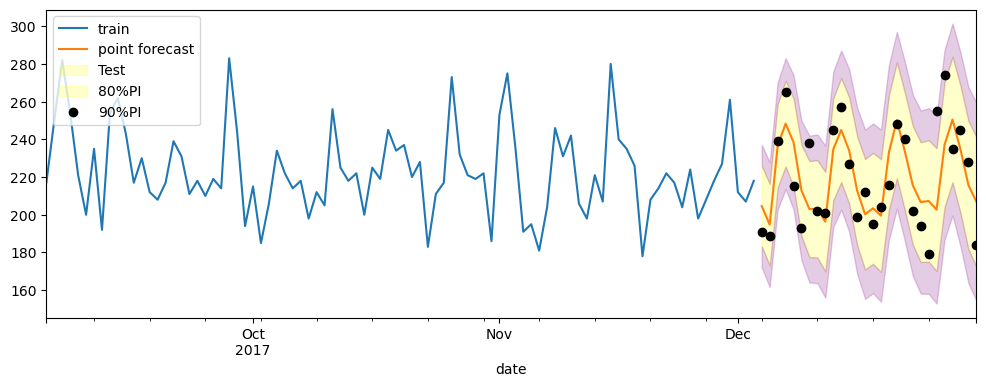

In [14]:
plot_prediction_intervals(train, preds, intervals, test=test, 
                          show_train_size=90)